In [89]:
import gymnasium as gym
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import random
from collections import deque, namedtuple
from tqdm.auto import tqdm
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim

from gymnasium.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import io, base64

In [90]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [91]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

num_states, num_actions

(8, 4)

In [92]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.transition = namedtuple("Transition", field_names=["state", "action", "reward", "next_state", "done"])
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        transition = self.transition(*args)
        self.memory.append(transition)
    
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)

        states = torch.from_numpy(np.vstack([transition.state for transition in transitions if transition is not None])).float()
        actions = torch.from_numpy(np.vstack([transition.action for transition in transitions if transition is not None])).long()
        rewards = torch.from_numpy(np.vstack([transition.reward for transition in transitions if transition is not None])).float()
        next_states = torch.from_numpy(np.vstack([transition.next_state for transition in transitions if transition is not None])).float()
        dones = torch.from_numpy(np.vstack([transition.done for transition in transitions if transition is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [93]:
# HYPERPARAMETERS
BATCH_SIZE = 64
GAMMA = 0.99
ALPHA = 5e-4
REPLAY_MEMORY_SIZE = int(1e5)
UPDATE_RATE = 5
# EPSILON = 1.0
# EPSILON_DECAY = 0.9995
# EPSILON_MIN = 0.01
TAU = 1e-3

class DQNAgent():
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions

        self.policy_net = DQN(n_states, n_actions)
        self.target_net = DQN(n_states, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.memory = ReplayMemory(REPLAY_MEMORY_SIZE)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=ALPHA)
        self.loss_fn = nn.MSELoss()

        self.steps_done = 0

    def select_action(self, state, epsilon=0.):
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.policy_net.eval()
        with torch.inference_mode():
            action_values = self.policy_net(state)
        self.policy_net.train()

        random_number = random.random()
        if random_number > epsilon:
            return np.argmax(action_values.detach().numpy())
        else:
            return random.choice(np.arange(self.n_actions))
        
    def make_transition(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

        self.steps_done += 1
        if self.steps_done % UPDATE_RATE == 0:
            if len(self.memory) > BATCH_SIZE:
                self.optimize_model()
        
    def optimize_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

        q_targets = rewards + GAMMA * self.target_net(next_states).max(1)[0].unsqueeze(1) * (1 - dones)
        q_expected = self.policy_net(states).gather(1, actions)

        loss = self.loss_fn(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.policy_net, self.target_net)

    def soft_update(self, policy_net, target_net):
        for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)
        

In [94]:
episode_scores = []

In [95]:
def plot_scores(show_result=False):
    plt.figure(1)
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(scores_t.numpy())
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [96]:
# HYPERPARAMETERS
BATCH_SIZE = 64
GAMMA = 0.99
ALPHA = 5e-4
REPLAY_MEMORY_SIZE = int(1e5)
UPDATE_RATE = 5
# EPSILON = 1.0
# EPSILON_DECAY = 0.9995
# EPSILON_MIN = 0.01
TAU = 1e-3
EPISODES = 2500
MAX_TIMESTEPS = 1000

def train(agent):
    EPSILON = 1.0
    EPSILON_DECAY = 0.9995
    EPSILON_MIN = 0.1
    for episode in tqdm(range(EPISODES)):
        state = env.reset()[0]
        score = 0

        for t in range(MAX_TIMESTEPS):
            action = agent.select_action(state, EPSILON)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.make_transition(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                episode_scores.append(score)
                plot_scores()
                EPSILON = max(EPSILON_MIN, EPSILON_DECAY * EPSILON)
                break
        

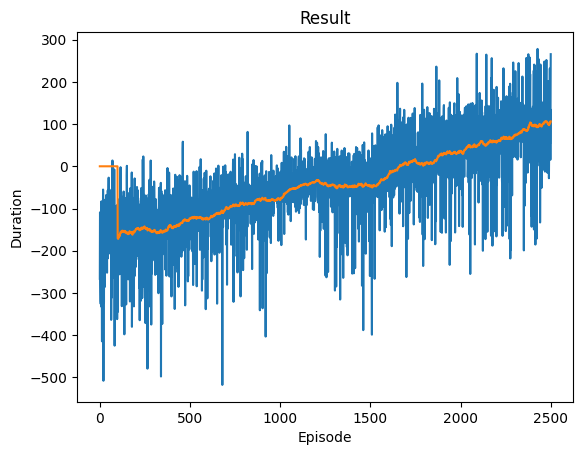

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [97]:
agent = DQNAgent(num_states, num_actions)
train(agent)

plot_scores(show_result=True)
plt.ioff()
plt.show()

In [60]:
state = env.reset()[0]
type(state)

numpy.ndarray

In [103]:
env.close()

In [104]:
env = gym.make('LunarLander-v2', render_mode='human')

In [109]:
# Test the agent
def test(env, agent, loop=3):
    for i in range(loop):
        state = env.reset()[0]
        for idx in range(500):
            action = agent.select_action(state, epsilon=0)
            state, reward, terminated, truncated, _ = env.step(action)
            env.render()
            if terminated or truncated:
                break


In [111]:
test(env, agent, loop=10)